# Matrix-based scaling experiment
> More scaling, this time with the matrix-based generator and solver

Updated Nov 29, 2022

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

In [5]:
plt.rc("font", size=20)

In [3]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [4]:
# This takes about 5 minutes for 100 samples
abundances, log2_ptrs, otus = make_tables(
    n_genomes=10,
    n_samples=20,
    db=rnadb,
    sparsity=0,
    multiplier=1
)

In [6]:
solver = TorchSolver(otus=otus, db=rnadb)

Using OTU index for md5s


In [7]:
def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


# Effect of number of genomes

In [8]:
results = pd.DataFrame()
for n_genomes in range(1, 20):
    print(n_genomes)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=n_genomes,
        n_samples=20 - n_genomes,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=1,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    solver.train(lr=0.1, clip=True, model_bias=False)
    B_scores, A_scores, B_inf, A_inf = score(
        solver=solver,
        true_log2_ptrs=log2_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                results = results.append(
                    {
                        "n_genomes": n_genomes,
                        "genome": genome_id,
                        "sample": sample_id,
                        "true_ptr": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": abundances.loc[genome_id, sample_id],
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[
                            rnadb[genome_id]["md5"].unique(), sample_id
                        ].sum(),
                    },
                    ignore_index=True,
                )
            except KeyError as e:
                print(f"=====KEY ERROR: {e}")

results


1
Using OTU index for md5s
Initial:	 -518.1017456054688
Epoch 0:	 -3934.85205078125
Epoch 1:	 -4391.18408203125
Epoch 2:	 -4670.60693359375
Epoch 3:	 -4875.94384765625
Epoch 4:	 -5037.8740234375
Epoch 5:	 -5168.89990234375
Epoch 6:	 -5275.158203125
Epoch 7:	 -5360.41259765625
Epoch 8:	 -5427.68310546875
Epoch 9:	 -5479.6748046875
Epoch 10:	 -5518.99169921875
Epoch 11:	 -5547.97802734375
Epoch 12:	 -5568.70703125
Epoch 13:	 -5583.16552734375
Epoch 14:	 -5593.18359375
Epoch 15:	 -5600.07763671875
Epoch 16:	 -5604.82177734375
Epoch 17:	 -5607.99658203125
Epoch 18:	 -5610.07080078125
Epoch 19:	 -5611.37646484375
Epoch 20:	 -5612.16064453125
Epoch 21:	 -5612.5615234375
Epoch 22:	 -5612.71533203125
Epoch 23:	 -5612.8095703125
Epoch 24:	 -5612.89794921875
Epoch 25:	 -5612.96484375
Epoch 26:	 -5613.0029296875
Epoch 27:	 -5613.01904296875
Epoch 28:	 -5613.021484375
Epoch 29:	 -5613.02197265625
Epoch 30:	 -5613.02197265625
Epoch 31:	 -5613.02197265625
Epoch 32:	 -5613.02197265625
Epoch 33:	 -561

,abundance,abundance_score,genome,inferred_abundance,inferred_ptr,n_genomes,n_reads,ptr_score,sample,true_ptr
0,0.949674,-267.477512,979982.3,268.427185,1.178207,1.0,1003.0,0.051632,0.0,1.229839
1,2.854522,-864.423738,979982.3,867.278259,1.118236,1.0,3311.0,-0.003138,1.0,1.115098
2,0.628182,-211.558356,979982.3,212.186539,1.815455,1.0,669.0,-0.347510,2.0,1.467945
3,0.989533,-283.576629,979982.3,284.566162,1.101974,1.0,1093.0,0.165587,3.0,1.267561
4,3.171924,-959.830761,979982.3,963.002686,1.108567,1.0,3690.0,-0.023523,4.0,1.085044
...,...,...,...,...,...,...,...,...,...,...
1325,2.492376,-743.909724,1616788.3,746.402100,1.025328,19.0,6681.0,0.041641,0.0,1.066969
1326,2.984538,-861.086629,743973.3,864.071167,1.024529,19.0,1699.0,0.084783,0.0,1.109312
1327,1.458867,-466.165675,706191.3,467.624542,1.691503,19.0,2433.0,-0.224432,0.0,1.467071
1328,0.614614,-189.138896,264199.4,189.753510,1.369008,19.0,1082.0,-0.136397,0.0,1.232611


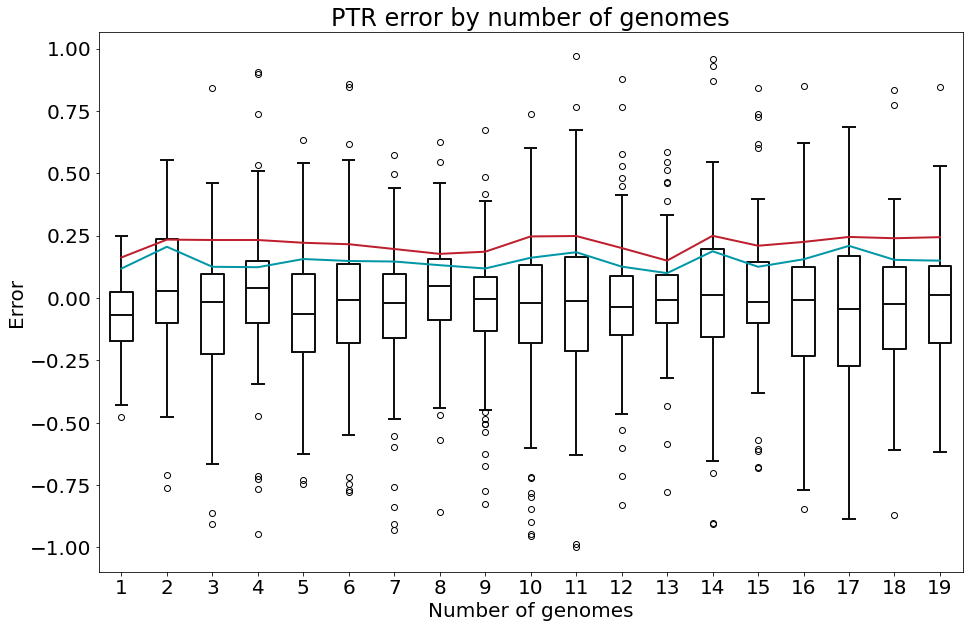

In [36]:
results.boxplot(
    by="n_genomes", 
    column="ptr_score", 
    figsize=(15, 10), 
    grid=False,
)

# Make boxplots thicker and #111111
for i, artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        artist.set_color("#111111")
        artist.set_linewidth(2)

# Draw error on same figure with different y axis
plt.plot(np.arange(1, 20), results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").mean()["ptr_score"], c="#BE1E2D", lw=2)
plt.plot(np.arange(1, 20), results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").median()["ptr_score"], c="#0097A7", lw=2)
plt.ylabel("Error")
plt.xlabel("Number of genomes")
plt.title("PTR error by number of genomes")
plt.suptitle("")

# Convert xlabel to integers
plt.xticks(np.arange(1, 20), np.arange(1, 20))

plt.show()

Text(0.5, 1.0, 'PTR agreement in genome size experiment')

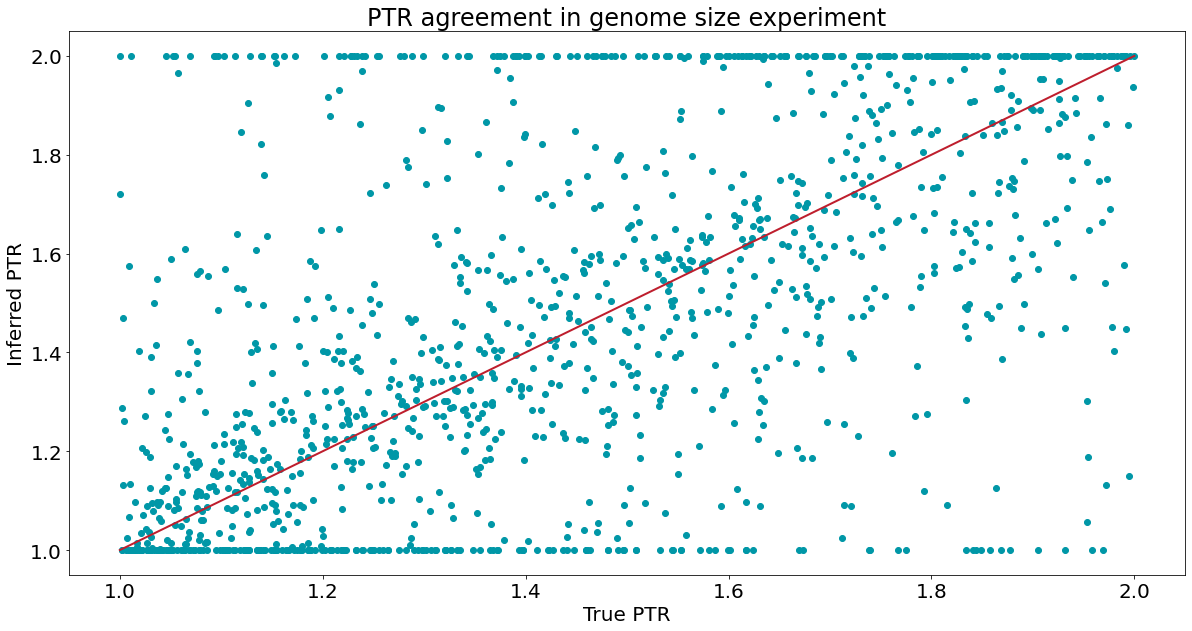

In [33]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["true_ptr"], results["inferred_ptr"], c="#0097A7")
plt.plot([1,2], [1,2], c="#BE1E2D", lw=2)
plt.xlabel("True PTR")
plt.ylabel("Inferred PTR")
plt.title("PTR agreement in genome size experiment")

# Effect of scaling factor

In [38]:
results_scaling = pd.DataFrame()
for scaling_factor in range(-5, 4):
    print(scaling_factor)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=5,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=10**scaling_factor,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    try:
        solver.train(lr=0.1, clip=True)
    except Exception as e:
        print(e)
        continue
    B_scores, A_scores, B_inf, A_inf = score(
        solver=solver,
        true_log2_ptrs=log2_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                results_scaling = results_scaling.append(
                    {
                        "scaling": scaling_factor,
                        "genome": genome_id,
                        "sample": sample_id,
                        "true_ptr": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": abundances.loc[genome_id, sample_id],
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[
                            rnadb[genome_id]["md5"].unique(), sample_id
                        ].sum(),
                    },
                    ignore_index=True,
                )
            except Exception as e:
                print(e)

results_scaling


-5
Using OTU index for md5s
Initial:	 0.9244518280029297
Epoch 0:	 0.04545454680919647
Epoch 1:	 0.04545454680919647
Epoch 2:	 0.04545454680919647
Epoch 3:	 0.04545454680919647
Epoch 4:	 0.04545454680919647
Epoch 5:	 0.04545454680919647
Epoch 6:	 0.04545454680919647
-4
Using OTU index for md5s
Initial:	 0.9744030833244324
Epoch 0:	 0.13463042676448822
Epoch 1:	 0.13463042676448822
Epoch 2:	 0.13463042676448822
Epoch 3:	 0.13463042676448822
Epoch 4:	 0.13463056087493896
Epoch 5:	 0.13463141024112701
Epoch 6:	 0.1346307396888733
-3
Using OTU index for md5s
Initial:	 0.9515359401702881
Epoch 0:	 0.43557342886924744
Epoch 1:	 0.43557342886924744
Epoch 2:	 0.43557339906692505
Epoch 3:	 0.4355747699737549
Epoch 4:	 0.4355738162994385
Epoch 5:	 0.43557342886924744
Epoch 6:	 0.435575932264328
Epoch 7:	 0.4355737268924713
Epoch 8:	 0.4355737268924713
-2
Using OTU index for md5s
Initial:	 -3.2809455394744873
Epoch 0:	 -14.055231094360352
Epoch 1:	 -14.055224418640137
Epoch 2:	 -14.05524444580078

,abundance,abundance_score,genome,inferred_abundance,inferred_ptr,n_reads,ptr_score,sample,scaling,true_ptr
0,0.694865,0.694865,228400.7,0.000000,2.000000,0.0,-0.813242,1.0,-5.0,1.186758
1,2.052106,1.340968,228400.7,0.711138,1.987864,1.0,-0.661962,19.0,-5.0,1.325902
2,1.052784,1.052784,1302863.3,0.000000,2.000000,0.0,-0.457571,1.0,-5.0,1.542429
3,3.066775,3.066775,1302863.3,0.000000,2.000000,0.0,-0.827625,19.0,-5.0,1.172375
4,1.766016,1.766016,1304866.3,0.000000,2.000000,0.0,-0.790044,1.0,-5.0,1.209956
...,...,...,...,...,...,...,...,...,...,...
775,0.208789,-34.368073,525898.7,34.576862,1.516469,158483.0,0.121931,15.0,3.0,1.638400
776,0.461160,-76.217879,525898.7,76.679039,1.833771,330744.0,0.123122,16.0,3.0,1.956893
777,1.949790,-320.810739,525898.7,322.760529,1.630381,1446180.0,0.121299,17.0,3.0,1.751680
778,11.560337,-1905.325406,525898.7,1916.885742,1.198037,9514194.0,0.091771,18.0,3.0,1.289808


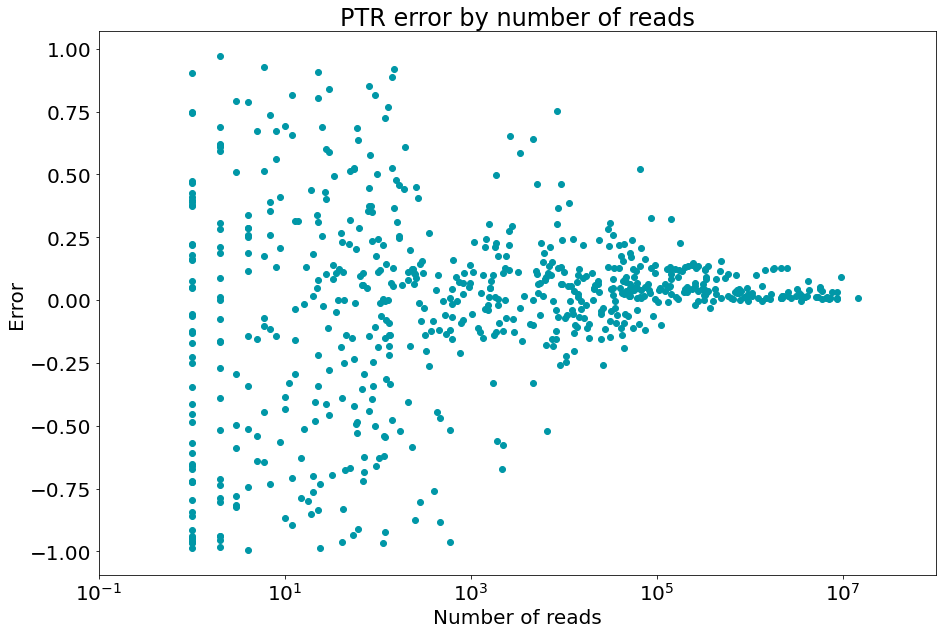

In [39]:
figure = plt.figure(figsize=(15, 10))

plt.scatter(results_scaling["n_reads"], results_scaling["ptr_score"], c="#0097A7")
plt.xscale("log")
plt.xlim([.1, 1e8])
plt.xlabel("Number of reads")
plt.ylabel("Error")
plt.title("PTR error by number of reads")
plt.show()